In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use("ggplot")
from ipywidgets import interact
import numpy as np
import matplotlib as mpl
import arrow
from matplotlib import animation, rc
from IPython.display import HTML
from datetime import timedelta


%matplotlib inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
#############################################################################
# Prepare data and import into a dataframe
#############################################################################

# Export Data from healthkit using [qs-access](https://itunes.apple.com/us/app/qs-access/id920297614?mt=8) app
exported_and_trandformed_csv_file = "data/weight.csv"
df = pd.read_csv(exported_and_trandformed_csv_file)

idx_weight_kg = "Weight (kg)"
idx_weight = "Weight (lbs)"
# make dateColumn a datetime.
idx_date = "Start"
df[idx_date] = pd.to_datetime(df[idx_date])
df = df.set_index(df[idx_date])
# Create Time Period Groups
idx_month_year = "month_year"
df[idx_month_year] = df.index.to_series().apply(lambda t: arrow.get(t).format("MMM-YY"))

idx_week_year = "week_year"
df[idx_week_year] = df.index.to_series().apply(lambda t: f"{t.week}-{t.year-2000}")

#########################
# Clean data
###########################

# Remove 0 weight values.
df = df.replace(0, np.nan)
# Throw away junk data at the start of time
df = df["2010/1/1":]  # type: ignore
# (not sure why mypy can't handle this)
# KG to lbs
df[idx_weight] = df[idx_weight_kg] * 2.2
dfW = df[idx_weight]


# Helpful time aliases
df_alltime = df

In [3]:
def box_plot_weight_over_time(df, x, title=""):
    # In theory can use plot.ly (not free)  or Bokeh (not mpl compatible) but issues. So setting dimensions old school.
    # Manually setting the weight and width.
    height_in_inches = 8
    mpl.rc("figure", figsize=(2 * height_in_inches, height_in_inches))

    ax = sns.boxplot(x=x, y=idx_weight, data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(title)
    ax.set_xlabel("date")
    ax.set_ylabel("lbs")
    plt.show()

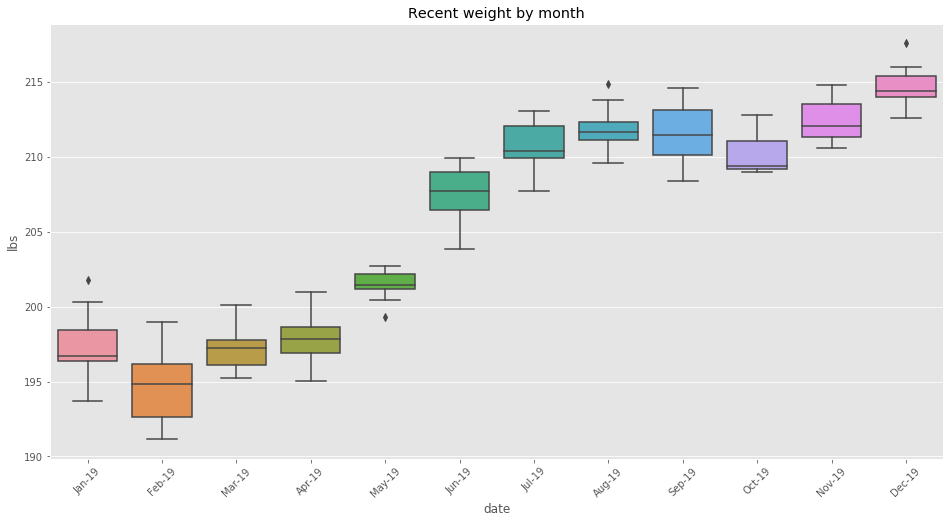

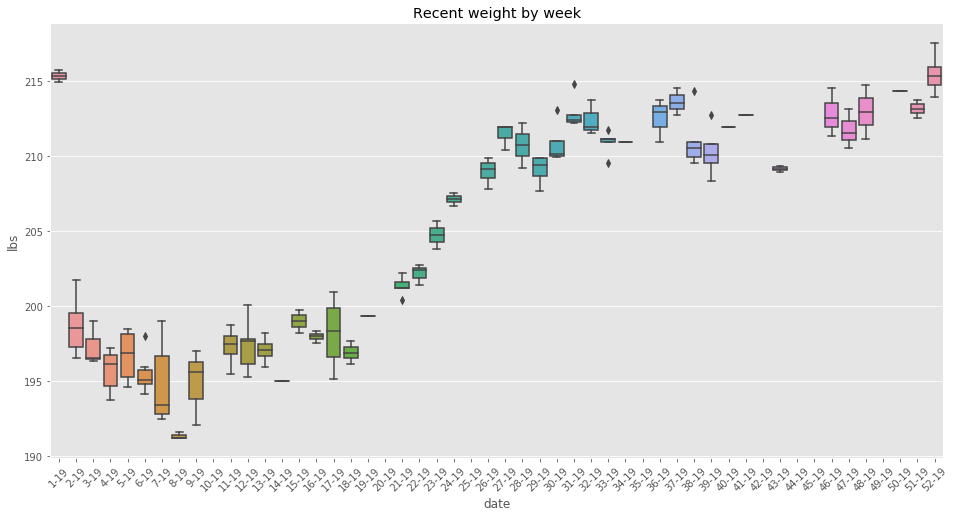

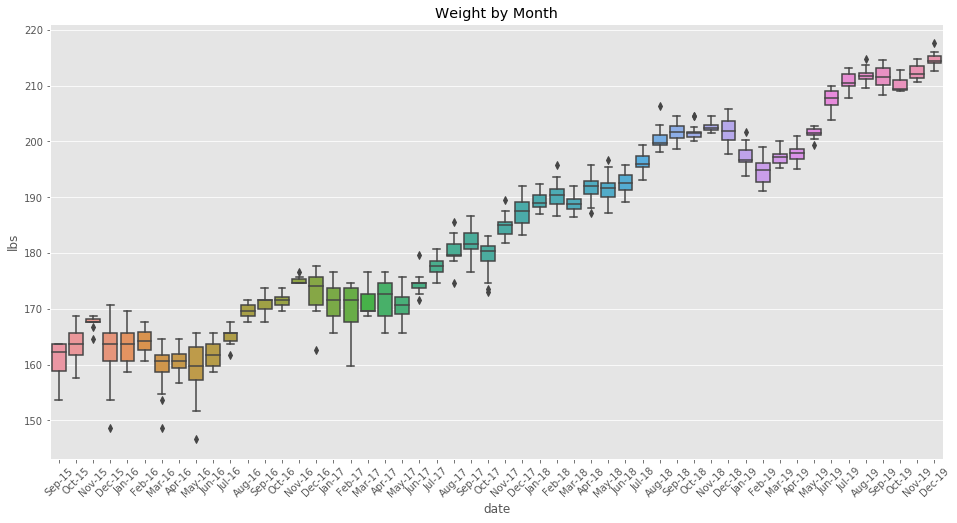

In [10]:
earliest = arrow.utcnow().shift(months=-12).date()
box_plot_weight_over_time(df[earliest:], idx_month_year, title="Recent weight by month")
box_plot_weight_over_time(df[earliest:], idx_week_year, title="Recent weight by week")
box_plot_weight_over_time(df_alltime, idx_month_year, "Weight by Month")

# Time Series Analysis using resampling

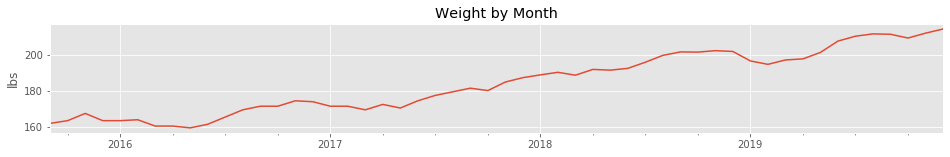

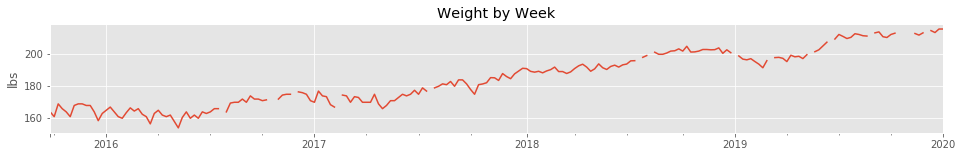

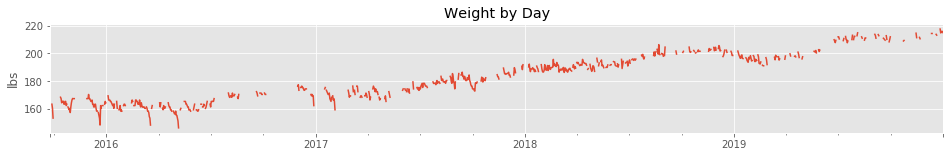

In [5]:
for freq in "Month Week Day".split():
    pandasFreqValue = freq[0]  # hack, pandas Freq are D,W,M
    ax = (
        dfW.resample(pandasFreqValue)
        .median()
        .plot(title=f"Weight by {freq}", figsize=(16, 2))
    )
    ax.set_ylabel("lbs")
    ax.set_xlabel("")
    plt.show()
# Can graph interactively using Bokeh @
# https://stackoverflow.com/questions/45972782/plot-time-series-graph-using-bokeh

In [6]:
dfM = dfW.resample("W").median()

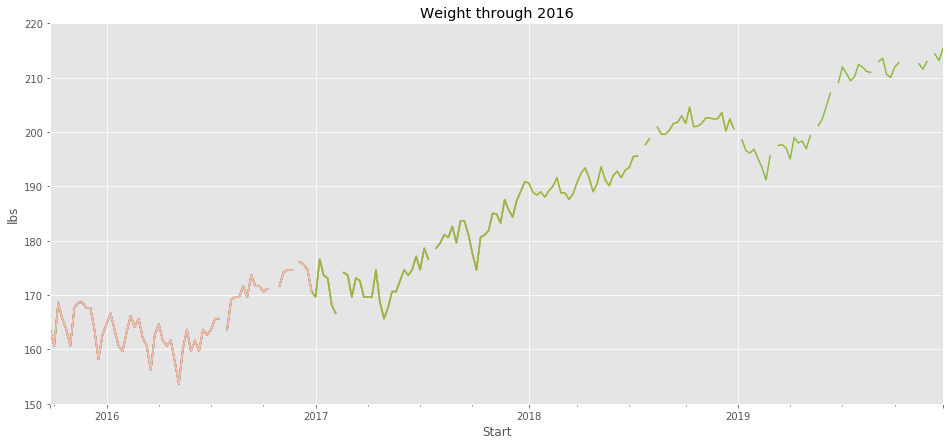

In [7]:
anim_year_base = 2016
anim_fig_size = (16, 7)
fig = plt.figure(figsize=anim_fig_size)
ax = fig.add_subplot(1, 1, 1)
dfM[:f"{anim_year_base}"].plot(
    title=f"Title Over Written", figsize=anim_fig_size, ylim=(150, 220), ax=ax
)
ax.set_ylabel("lbs")
ax.set_xlabel("")


def animate(i):
    year = f"{anim_year_base+i}"
    return dfM[:year].plot(title=f"Weight through {year}").lines


anim = animation.FuncAnimation(
    fig, animate, frames=4, interval=timedelta(seconds=2).seconds * 1000, blit=False
)
HTML(anim.to_html5_video())
# TODO - how to get rid of the initial plot from animate.init() -- no clue.